In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
sns.set()

## Loading the data

In [2]:
# 50 pages of data scraped, 1000 observations
raw_data = pd.read_excel('StanoviBGD-2021-02-25-50pages.xlsx')
raw_data.head()

,Unnamed: 0,City,Municipality,Part_of_the_city,Size,Rooms,Floor,Total floors,Price,Price_per_m2,Type,Advertiser,Date
0,0,Beograd,Opština Zemun,Donji grad,69.0,3.0,VPR,8.0,145000,2101,Premium,Agencija,25.02.2021.
1,1,Beograd,Opština Zemun,Donji grad,51.0,2.0,II,8.0,109000,2137,Premium,Agencija,25.02.2021.
2,2,Beograd,Opština Zemun,Donji grad,46.0,2.0,II,8.0,99000,2152,Premium,Agencija,25.02.2021.
3,3,Beograd,Opština Savski venac,Dedinje,135.0,4.0,II,3.0,355000,2630,Premium,Agencija,22.02.2021.
4,4,Beograd,Opština Vračar,Kalenić pijaca,72.0,3.0,I,5.0,189000,2625,Premium,Agencija,25.02.2021.


In [3]:
# Removing excess data
# All the data we have is for Belgrade, thus we remove City
# There are more than 170 different parts of the city, thus I also removed them
# Price per m2 in combination with size will distort regression model
# Since the data is sourced from recent scraping, it shouldn't be important
# Size and Number of rooms are expected to corelate 
data = raw_data.drop([ 'Unnamed: 0', 'City', 'Part_of_the_city', 'Price_per_m2', 'Date', 'Rooms'],axis = 1)

##  Missing values

In [4]:
# Checking for null values
data.isnull().sum() 

Municipality     0
Size             0
Floor           57
Total floors    57
Price            0
Type             0
Advertiser       0
dtype: int64

In [5]:
# Since there are not that many cases I' ve decided to simplyremove them
data = data.dropna()

In [6]:
# Detecting otliers
data.describe()

,Size,Total floors,Price
count,943.000000,943.000000,943.000000
mean,72.548876,6.100742,150637.531283
std,32.941880,3.759126,92942.711512
min,1.000000,1.000000,1050.000000
25%,51.000000,4.000000,85500.000000
50%,66.000000,5.000000,128000.000000
75%,87.000000,7.000000,180000.000000
max,355.000000,30.000000,750000.000000


## Cleaning outliers

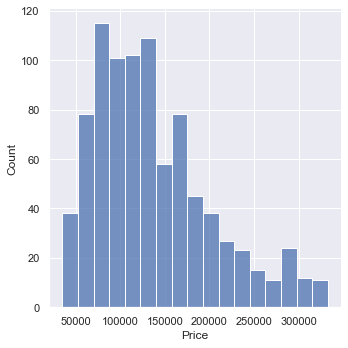

In [7]:
# Removing outliers for price, since there were not that many I' ve decided to trimp top 5 and bottom 1 percentile
# Prices are still a bit skewed to the left
qpmax = data['Price'].quantile(0.95)
qpmin = data['Price'].quantile(0.01)
data2 = data[data['Price'].between(qpmin, qpmax)]
sns.displot(data2['Price'])

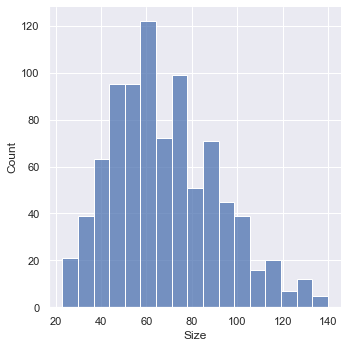

In [8]:
# Size outliers, removed top and bottom 1 percentile
qsmax = data2['Size'].quantile(0.99)
qsmin = data2['Size'].quantile(0.01)
data_cleaned = data2[data2['Size'].between(qsmin, qsmax)]
sns.displot(data_cleaned['Size'])

In [9]:
# After data cleaning, we ended up with about 90% of the originial data
# Data is still a bit skewed, but I think that shouldnt pose a problem
data_cleaned.describe()

,Size,Total floors,Price
count,872.000000,872.000000,872.000000
mean,68.272775,6.146789,137023.307339
std,23.489338,3.723080,64562.092509
min,23.000000,1.000000,35000.000000
25%,50.690000,4.000000,85050.000000
50%,65.000000,5.000000,124950.000000
75%,84.000000,7.000000,172000.000000
max,140.000000,30.000000,332888.000000


## Transforming categorical variables

In [10]:
data_transformed = data_cleaned.copy()

### Municipality

In [11]:
# formatting data
data_transformed['Municipality'] = data_transformed['Municipality'].map(lambda x: x.replace('Opština ', '').replace('\xa0',''))

### Floors

In [12]:
# Values for floors were given in Roman alphabet, with some codes
data_transformed['Floor'].unique()

array(['VPR', 'II', 'I', 'PR', 'IV', 'III', 'V', 'VI', 'VII', 'VIII',
       'XI', 'XII', 'X', 'XIII', 'IX', 'XIX', 'XVI', 'XIV', 'XV', 'SUT',
       'PSUT', 'XVIII'], dtype=object)

In [13]:
# Quick function to transform roman to arabic numbers, prone to errors, doesn't check if proper roman numbers are used
def to_arabic(r_nr):
    roman_pairs = {'I': 1, 'V': 5, 'X': 10, 'L': 50}
    r_nr = r_nr.upper()
    total = roman_pairs[r_nr[0]] # 1st character transformed into arabic
    if len(r_nr) == 1:
        return total
    else:
        for i in range(1, len(r_nr)): #Ignoring first case..
            nr = roman_pairs[r_nr[i]]
            if r_nr[i] <= r_nr[i-1]:
                total += nr
            else:
                total -= nr
        return abs(total) # Abs because it will calculate IV as -4 and IX as -9...

In [14]:
# I have decided to transform PR, SUT and PSUT
# Prizemlje - ground floor, Suteren basement?, PSUT - ground floor/ basement) as Floor 0
# and VPR (visoko prizemlje - higher ground floor) as Floor 1
# Hard coding non roman values and then appending roman ones

value_pairs = {'PR':0, 'SUT': 0, 'PSUT':0 ,'VPR': 1} 
for num in data_transformed['Floor'].unique():
    try:
        value_pairs[num] =(to_arabic(num))
    except:
        pass    
data_transformed['Floor'] = data_transformed['Floor'].map(value_pairs)

### Dummies

In [15]:
data_transformed = pd.get_dummies(data_transformed, drop_first = True)

## Regression

### Fitting the model

In [16]:
y = data_transformed['Price']
X = data_transformed.drop('Price', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 5)
reg = LinearRegression(normalize = True).fit(X_train, y_train)

### Scores

In [17]:
res = pd.DataFrame((reg.score(X_train, y_train), reg.score(X_test, y_test)), index = ['Train score','Test score'], columns = [''])
res
# The model explains 75% of the price varriance on the training dataset, and 72% on the test set

,
Train score,0.757524
Test score,0.721460


### Plotting the model

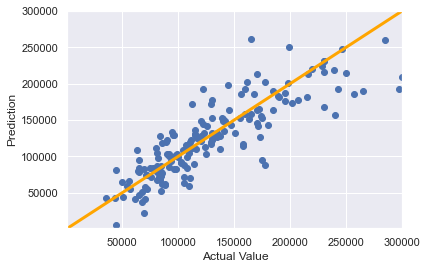

In [18]:
# Predictions are less accurate for more expensive apartments
y_hat_test = reg.predict(X_test)
plt.scatter(y_test, y_hat_test)
plt.xlabel('Actual Value')
plt.ylabel('Prediction')
plt.xlim(1000,300000)
plt.ylim(1000,300000)
plt.plot([0,300000],[0,300000], color = 'orange', linewidth = 3)
plt.show()

## Regression and error summary tables

### Regression table

In [19]:
# Summary: 'Top' appartments are on average cheaper than 'Premium'
# Agency is selling on average for more then investitor or owner
# and price varies greatly between municipalities
reg_table = pd.DataFrame(X.columns.values, columns = ['Features'])
reg_table['Weights'] = reg.coef_
reg_table

,Features,Weights
0,Size,2054.324257
1,Floor,-949.905479
2,Total floors,2192.816476
3,Municipality_Novi Beograd,37130.014094
4,Municipality_Palilula,28627.361083
5,Municipality_Rakovica,-11030.080608
6,Municipality_Savski venac,54574.148483
7,Municipality_Stari grad,71115.280385
8,Municipality_Voždovac,19458.615673
9,Municipality_Vračar,72071.311024


### Error summary

In [20]:
err = pd.DataFrame((y_hat_test), columns = ['Prediction'])
err['Targets'] = y_test.reset_index(drop=True)
err['Residual'] = abs(err['Prediction'] - err['Targets'])
err['Difference%'] = err['Residual']/err['Targets']*100
err.describe()

,Prediction,Targets,Residual,Difference%
count,175.000000,175.000000,175.000000,175.000000
mean,126402.558269,131821.748571,22760.778251,18.407932
std,54396.729881,61436.889166,23028.618056,16.407915
min,4961.984175,35000.000000,143.273107,0.153233
25%,83606.070171,84950.000000,6983.163562,5.821558
50%,121059.196066,116000.000000,15262.841445,13.880963
75%,163793.339725,166500.000000,30639.931176,26.856119
max,261152.941073,332888.000000,139197.232320,88.849474
